# What Type of Free Apps attract users?
#### Goal: Explore which kind of free apps are more popular on Google play and Apple store and which age group is associated with the popularity.
Since collecting over 4 million apps available on App store and Google Play will be fairly difficult, we will only be analyzing the subset of data from **2017-2018**.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [48]:
google = pd.read_csv('googleplaystore.csv')
print(google.shape)
google.head(3)

(10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [49]:
apple = pd.read_csv('AppleStore.csv')
print(apple.shape)
apple.head(3)

(7197, 16)


,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,284882215,Facebook,389879808,USD,0.0,2974676,212,3.5,3.5,95.0,4+,Social Networking,37,1,29,1
1,389801252,Instagram,113954816,USD,0.0,2161558,1289,4.5,4.0,10.23,12+,Photo & Video,37,0,29,1
2,529479190,Clash of Clans,116476928,USD,0.0,2130805,579,4.5,4.5,9.24.12,9+,Games,38,5,18,1


There are **10841** apps in **Google Play** and **7197** apps in **App store**. Google Play contains more apps available to download.

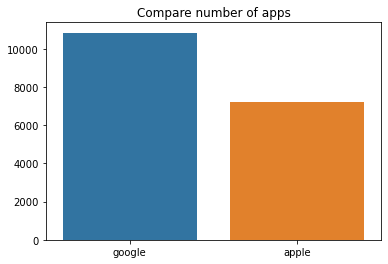

In [50]:
sns.barplot(data = pd.DataFrame({'google': [len(google)], 'apple': [len(apple)]}))
plt.title("Compare number of apps")
plt.show()

# Data Cleaning
Since we want to analyze the data more conveniently, we want to clean the data by removing
- columns that are not helpful
- wrong entry sample
- non-english apps
- dupilcated entry
- paid apps
- rows with too many na values


### Google

We keep only essential columns, remove the wrong entry where column entries are mixed up, and keep one app with the highest reviews out of all repeated apps.

In [51]:
#drop non important columns
google_cleaned = google.copy()
google_cleaned = google_cleaned.drop(columns = ['Genres', 'Last Updated', 'Current Ver', 'Android Ver'])

#remove duplicate entry
def remove_dup(df, col, review):
    boo = df[col].value_counts() > 1
    dup_apps = df[col].value_counts().index[boo] #find out duplicated app names
    del_dup_ind = []

    for app in dup_apps:
        temp_df = df[df[col] == app].sort_values(review)
        del_dup_ind.append(temp_df[1:].index[0])
        
    return del_dup_ind

# a peak at duplicated apps
u = google_cleaned.iloc[google_cleaned.index.isin(remove_dup(google_cleaned, 'App', 'Reviews')),:]['App'].unique()
print(google_cleaned[google_cleaned['App'].isin(u[:3])].sort_values('App'))

google_cleaned.drop(index = remove_dup(google_cleaned, 'App', 'Reviews'), inplace = True)

#remove wrong entry
google_cleaned.drop(index = 10472, inplace = True)
google[google['Type'] == '0'] #a peak at 10472th row

                                        App       Category  Rating  Reviews  \
206                            Call Blocker       BUSINESS     4.6   188841   
436                            Call Blocker  COMMUNICATION     4.1    17529   
194  OfficeSuite : Free Office + PDF Editor       BUSINESS     4.3  1002861   
293  OfficeSuite : Free Office + PDF Editor       BUSINESS     4.3  1002859   
222            Quick PDF Scanner + OCR FREE       BUSINESS     4.2    80805   
229            Quick PDF Scanner + OCR FREE       BUSINESS     4.2    80805   
285            Quick PDF Scanner + OCR FREE       BUSINESS     4.2    80804   

                   Size      Installs  Type Price Content Rating  
206                3.2M    5,000,000+  Free     0       Everyone  
436                 10M    1,000,000+  Free     0       Everyone  
194                 35M  100,000,000+  Free     0       Everyone  
293                 35M  100,000,000+  Free     0       Everyone  
222  Varies with device    5,000

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


I also remove non English apps and convert the Reviews column to float type instead of object type. 
<br>Also, I added a useful column of number of installs in numerical value instead of categorical. 
These numbers may not be accurately true since they are rounded to nearest thousands or millions to form categories, but they can represent lower bounds of the number of installs.

In [52]:
#remove non english apps
def remove_non_english(df,col):
    del_ind = []

    for app, ind in zip(df[col], df.index):
        non_eng_ch_count = 0
        for ch in app:        
            if ord(ch) > 127:
                non_eng_ch_count += 1
        if non_eng_ch_count > 5:        
            del_ind.append(ind)
    return del_ind

del_ind_g = remove_non_english(google_cleaned, 'App')
print('A peak of non english apps:\n', google.iloc[del_ind_g[:3],:]["App"])# a peak at non english apps
google_cleaned.drop(index= del_ind_g, inplace = True)

# remove rows with too many na values
google_cleaned.dropna(axis = 0, thresh = 5, inplace = True)

# convert Reviews to numerical
google_cleaned['Reviews'] = google_cleaned['Reviews'].astype(float)



# add a column with numerical values of installs
google_cleaned['Installs_num'] = google_cleaned['Installs'].str.extract(r'([\d,]+)+'
                                                                       ).iloc[:,0].str.replace(',','').astype('float')


A peak of non english apps:
 710     Flame - درب عقلك يوميا
3750               РИА Новости
4193                 صور حرف H
Name: App, dtype: object


### Apple

The same cleaning procedure was done on the Apple Store data too.

In [53]:
#drop non important columns
apple_cleaned = apple.copy()
apple_cleaned = apple_cleaned.drop(columns = ['id',  'currency', 'rating_count_ver', 'user_rating_ver', 
                                              'ver', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic'])
#remove non-english apps
del_ind_a = remove_non_english(apple_cleaned, 'track_name')
apple_cleaned.drop(index= del_ind_a, inplace = True)

#remove duplicated entry
apple_cleaned.drop(index = remove_dup(apple_cleaned, 'track_name', 'rating_count_tot'), inplace = True)

#remove rows with too many na values
apple_cleaned.dropna(axis = 0, thresh = 5, inplace = True)

After cleaning both google and apple store data, I separate out the free apps for further analysis.

In [54]:
# paid apps
free_apple = apple_cleaned[apple_cleaned['price'] == 0.0]
free_google = google_cleaned[google_cleaned['Type'] == 'Free']

# Exploratory Data Analysis
- Which 5 categories are most popular in Google Play and App Store? 
- Does the content rating groups distribution vary among the top 5 popular categories in both stores?

*** Consider that popular categories are ones that have highest average number of reviews or install and rating count. The rating is not relevant here, since it does not represent how many people are using an app. 

I created tables to show the **categories** for highest number of **installs** and **review counts**. Table shown below is for Google Play.

In [55]:
pv_tab_g = pd.pivot_table(data = free_google, index = 'Category', values = ['Installs_num', 'Reviews']
                             ).sort_values(['Reviews', 'Installs_num'], ascending = False)
pv_tab_a = pd.pivot_table(data = free_apple, index = 'prime_genre', values =['rating_count_tot']
                             ).sort_values(['rating_count_tot'], ascending = False)

#Google Store App Category summary
pv_tab_g[:10]

,Installs_num,Reviews
Category,,
COMMUNICATION,7.103759e+07,1.740795e+06
SOCIAL,3.605874e+07,1.643889e+06
GAME,2.854711e+07,1.246659e+06
PHOTOGRAPHY,2.732471e+07,5.682268e+05
VIDEO_PLAYERS,2.763645e+07,4.621582e+05
SHOPPING,1.114859e+07,3.974751e+05
ENTERTAINMENT,2.037575e+07,3.853660e+05
TOOLS,1.146672e+07,3.080621e+05
EDUCATION,5.158800e+06,2.375357e+05


The plots are visualizations for the tables I created above. I found that **Communication** is the most popular category on Google Play and  **Reference** is the most popular genre on App Store, while **Social Networking** ranked the second popular in both stores.<br>
<br>From the results, we may say that adroid phone owners download more **entertainment** related apps than App Store users and App Store users are more keen to download **tools/applications**, since the 5 categories following social and communication in Google Play are 	__Game, photography, video players, shopping, and entertainment__ comparing to App Store's __Navigation, Music, Weather, Book, and Food & Drink__. 

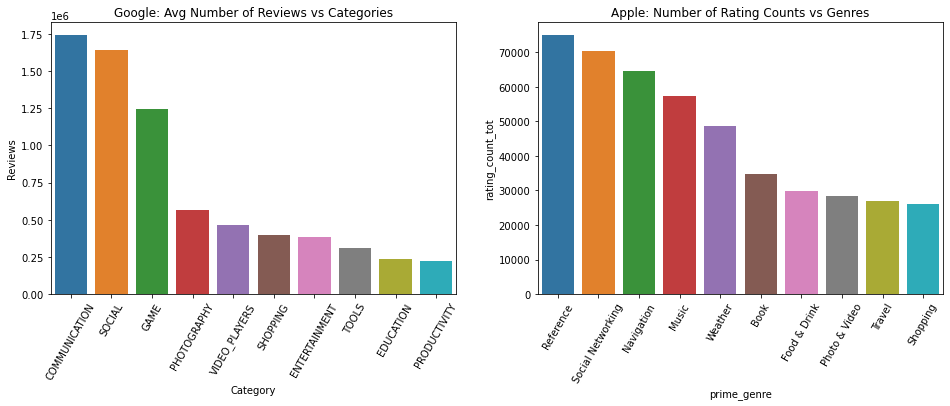

In [71]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
#google play
sns.barplot(data = pv_tab_g['Reviews'][:10].reset_index(level = 0), x= 'Category', y = 'Reviews', ax = axes[0])
axes[0].set_title('Google: Avg Number of Reviews vs Categories')

#app store
sns.barplot(data = pv_tab_a['rating_count_tot'][:10].reset_index(level = 0), x= 'prime_genre',
            y = 'rating_count_tot', ax = axes[1])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
    
axes[1].set_title('Apple: Number of Rating Counts vs Genres')
plt.show()


After discovering the popular categories, I decided to see the **distribution of content rating** in each category. Since the content rating in Google Store is not marked neatly as App Store, I decided to transform the content rating column in Google Play using App Store standard.

In [70]:
print(google['Content Rating'].unique())
print(apple['cont_rating'].unique())

['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated'
 nan]
['4+' '12+' '9+' '17+']


In [72]:
dict_map = {'Everyone':'4+', 
            'Teen':'12+',
            'Everyone 10+': '9+', 
            'Mature 17+': '17+', 
            'Adults only 18+': '17+', 
            'Unrated': None}
google_cleaned['Content Rating'] = google_cleaned['Content Rating'].map(dict_map)

The side by side pie charts below show the overall distribution of content rating in both stores. It shows that there are **16.7% more** apps in Google Play with content rating **age 4+** than App Store's, where as App Store has **6.5% more** apps rated **age 12 or more** than Google Play.

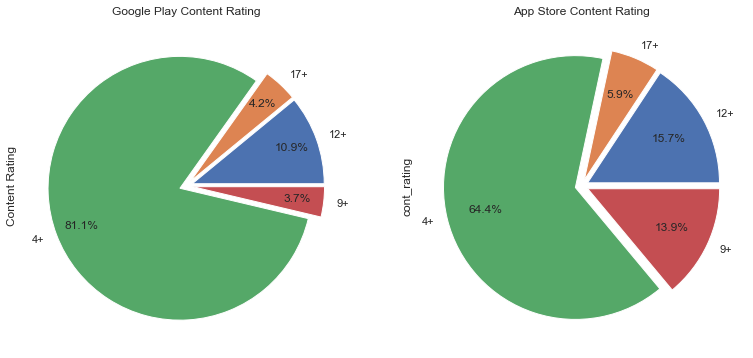

In [114]:
#content rating distribution
fig, ax = plt.subplots(1, 2, figsize = (13,13))
google_cleaned['Content Rating'].value_counts().sort_index().plot.pie(autopct="%.1f%%",  pctdistance=0.8, 
                                                                      explode = [0.05]*4, ax = ax[0])
ax[0].set_title("Google Play Content Rating")
apple_cleaned['cont_rating'].value_counts().sort_index().plot.pie(autopct="%.1f%%",  pctdistance=0.7, 
                                                                  explode = [0.05]*4, ax = ax[1])
ax[1].set_title("App Store Content Rating")
plt.show()

The bar plot shows the **app counts** for each category and the dots on the line plot shows the **sum of app counts** in each category. 
#### Observations:
- The plot below shows that **GAME** category contains a variety of content rating and has the **highest number of apps** among these 10 categories.
- The **17+** rating appears mostly in **Game, Social, and communication** apps. 
- Most of the categories except entertainment have more age **4+** than other age content rating, and this echoes the result of the distribution of the overall content rating above.

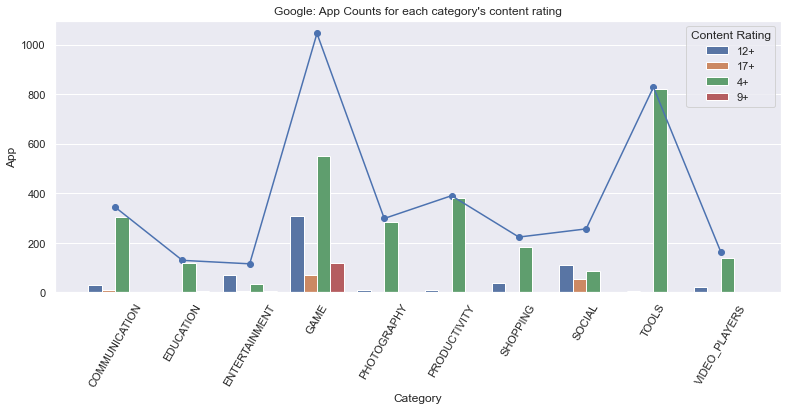

In [155]:
#index for top 10 categories in Google Play and App Store
top10_ind_g = pv_tab_g.index[:10]
top10_ind_a = pv_tab_a.index[:10]

#Counts for each category's content rating
pv_cont_rat = pd.pivot_table(data = google_cleaned[google_cleaned['Category'].isin(top10_ind_g)], 
               index = ['Category', 'Content Rating'], 
               values = 'App', aggfunc = len).reset_index(level= 1).reset_index(level= 0)

#Counts for each category
counts_cat = pd.pivot_table(data = google_cleaned[google_cleaned['Category'].isin(top10_ind_g)],
                   index = 'Category', values = 'App', aggfunc = len).reset_index(level = 0)

#bar plot
sns.barplot(data = pv_cont_rat, y = 'App', x = 'Category', hue = 'Content Rating')
sns.set(rc={'figure.figsize':(13,5)})

#line plot
plt.plot(counts_cat['Category'], counts_cat['App'])
plt.scatter(counts_cat['Category'], counts_cat['App'], label = 'App Count')\


plt.xticks(rotation = 60)
plt.title('Google: App Counts for each category\'s content rating')
plt.show()

#### Observations:
- **Photo & Video** Category has the **highest number** of apps among these 10 categories, then second comes **music**, even though they **are not** the categories with highest average reviews.
- The age limit of **17+** is also most prominent in **Social & Networking**.
- Again, the number of apps of **4+** content rating dominates other content ratings in these categories, but there are also **more types** of content rating per category compared to Google Play Store.

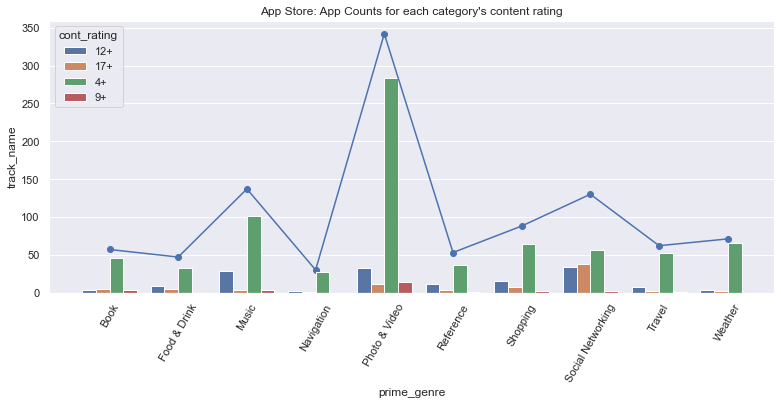

In [156]:
#index for top 10 categories in Google Play and App Store
top10_ind_g = pv_tab_g.index[:10]
top10_ind_a = pv_tab_a.index[:10]

#Counts for each category's content rating
pv_cont_rat = pd.pivot_table(data = apple_cleaned[apple_cleaned['prime_genre'].isin(top10_ind_a)], 
               index = ['prime_genre', 'cont_rating'], 
               values = 'track_name', aggfunc = len).reset_index(level= 1).reset_index(level= 0)

#Counts for each category
counts_cat = pd.pivot_table(data = apple_cleaned[apple_cleaned['prime_genre'].isin(top10_ind_a)], 
                   index = 'prime_genre', values = 'track_name', aggfunc = len).reset_index(level = 0)

#bar plot
sns.barplot(data = pv_cont_rat, y = 'track_name', x = 'prime_genre', hue = 'cont_rating')
sns.set(rc={'figure.figsize':(13,5)})

#line plot
plt.plot(counts_cat['prime_genre'], counts_cat['track_name'])
plt.scatter(counts_cat['prime_genre'], counts_cat['track_name'])

plt.xticks(rotation = 60)
plt.title('App Store: App Counts for each category\'s content rating')
plt.show()

### Conclusion:
- Even though some categories are popular, they **are not** categories with most number of apps. This may due to the profitability of app, such as the tradeoff between the cost of making an app and the marketing of the app is too high to build a popular app.
- **Social** and **Communication** apps are given age limits more than other groups in both stores. This is normal since there may be dating apps or social networking apps where children are not adviced to use until a certain age.
- App Store seems more strict on content rating, because there are more varieties of content rating in each categories, while many categories in Google Play only have **1~2** kinds with age **4+** or **12+** ratings. This may imply that Google Play users are younger, while App Store users are older. Reason may be due to the pricing difference between more expensive IOS devices and Android devices with diversity of price ranges. 
